In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
import re
from PIL import Image
import json
import numpy as np

import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.preprocessing.text import tokenizer_from_json

from nltk.translate.bleu_score import corpus_bleu

In [2]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
BASE_DIR = './newsdata'
WORKING_DIR = './newsmodels'

## Extract image features from VGG16

In [5]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # # extract features
    feature = model.predict(image,verbose=0)
    # # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8000 [00:00<?, ?it/s]

In [5]:
pickle.dump(features, open(os.path.join(WORKING_DIR, 'newsfeaturesextracted.pkl'), 'wb'))

In [4]:
with open(os.path.join(WORKING_DIR, 'newsfeaturesextracted.pkl'), 'rb') as f:
    features = pickle.load(f)

## Preprocess and tokenize image captions

In [5]:
with open(os.path.join(BASE_DIR, 'news_captions_ner.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [6]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/8001 [00:00<?, ?it/s]

In [9]:
len(mapping)

8000

In [7]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = re.sub('[^<>_A-Za-z]', ' ',caption)
            # delete additional spaces
            caption = re.sub('\s+', ' ',caption)
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [11]:
mapping['4fd2a7ca8eb7c8105d8913b6_0']

['<PERSON> stars as a cando widow who moves to <GPE> in The Best Exotic Marigold Hotel']

In [8]:
clean(mapping)

In [13]:
mapping['4fd2a7ca8eb7c8105d8913b6_0']

['startseq <person> stars as cando widow who moves to <gpe> in the best exotic marigold hotel endseq']

In [9]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [15]:
len(all_captions)

8000

In [10]:
all_captions[:10]

['startseq <person> ring acrylic on papiermch from <date> on the wall jayson mussons <org> gouache on coffeetinted paper from <date> at <person> endseq',
 'startseq the knicks <person> battling <person> said the nets continually found mismatches endseq',
 'startseq another view of the edgar hoover building endseq',
 'startseq <person> who is transgender was arrested in <date> during domestic dispute in the bronx she said she was put in cell with men and was subjected to slurs by police officers endseq',
 'startseq on the subway between <org> and <fac> endseq',
 'startseq <person> as the screaming writhing newborn creature in the opening scene of <person> endseq',
 'startseq demonstrators and police officers clashed in <gpe> endseq',
 'startseq preservation volunteers from <gpe> scrubbing moss and the wax stains from candles off <person> headstone endseq',
 'startseq <person> leaving the courtroom during <date> of jury deliberations in <person> sexual assault trial at <gpe> endseq',
 's

In [11]:
tokenizer = Tokenizer(filters = '!"#$%&()*+,./:;=?@[\\]^`{|}~\t\n')
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [12]:
vocab_size

13617

In [13]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

107

In [77]:
tokenizer_json = tokenizer.to_json()
with open(WORKING_DIR+'/tokenizer.json', 'w') as fp:
    json.dump(tokenizer_json, fp)

## Train image captioner

In [14]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [13]:
np.savetxt(WORKING_DIR+'/news_train_id.txt',train, fmt='%s')
np.savetxt(WORKING_DIR+'/news_test_id.txt',test, fmt='%s')

In [15]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [16]:
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [17]:
# epochs = 10
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

225/225 [==============================] - 127s 563ms/step - loss: 2.6156


In [18]:
# model.save(WORKING_DIR+'/newstenepochs.h5')
model.save(WORKING_DIR+'/newstwentyepochs.h5')

## Generate captions with the model

In [19]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [23]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [24]:
def generate_caption(image_name,model,features,tokenizer,max_length):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    display(image)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)

In [25]:
test[:10]

['5922396295d0e024b5872194_4',
 '51c1d7c27e0d9c0839d29b3e_2',
 '570673aa38f0d86865ca551e_1',
 '5911d8d795d0e024b586fbf8_2',
 '5ae39b9c068401528a2ab2af_1',
 '5824b53695d0e0204d55fc12_0',
 '560db6e938f0d81aa77a51cb_0',
 '59e869e795d0e0246f210e74_14',
 '5602cf2638f0d84a40af501e_0',
 '515da18ecf28d0219d001110_1']

In [27]:
model_10 = load_model(WORKING_DIR+'/newstenepochs.h5')
model_20 = load_model(WORKING_DIR+'/newstwentyepochs.h5')
with open(WORKING_DIR+'/tokenizer.json') as f:
    tokenizer_data = json.load(f)
    loaded_tokenizer = tokenizer_from_json(tokenizer_data)

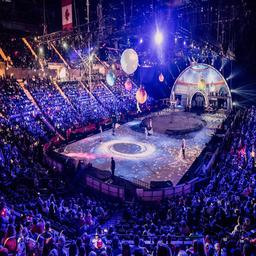

---------------------Actual---------------------
startseq the circuss operator decided to close it after prolonged slump in ticket sales but many in attendance on <date> said they believed the circus would somehow return perhaps retooled and rebranded endseq
--------------------Predicted--------------------
startseq the <org> vip juices in <gpe> endseq


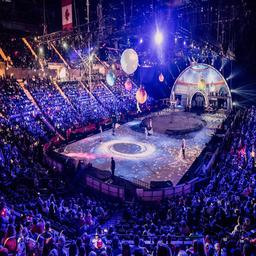

---------------------Actual---------------------
startseq the circuss operator decided to close it after prolonged slump in ticket sales but many in attendance on <date> said they believed the circus would somehow return perhaps retooled and rebranded endseq
--------------------Predicted--------------------
startseq the dance floor at the <org> awards show in <gpe> on <date> endseq


In [28]:
generate_caption("5922396295d0e024b5872194_4.jpg",model_10,features,loaded_tokenizer,107)
generate_caption("5922396295d0e024b5872194_4.jpg",model_20,features,loaded_tokenizer,107)

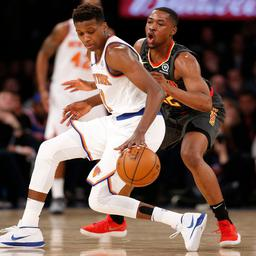

---------------------Actual---------------------
startseq ntilikina being guarded by <person> of <org> when the <org> selected <person> and <org> employees celebrated in the <gpe> draft room endseq
--------------------Predicted--------------------
startseq veteran forward <person> is averaging the <ordinal> appearances against the <ordinal> victory in the <ordinal> tournament endseq


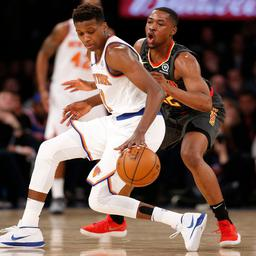

---------------------Actual---------------------
startseq ntilikina being guarded by <person> of <org> when the <org> selected <person> and <org> employees celebrated in the <gpe> draft room endseq
--------------------Predicted--------------------
startseq <person> left and teo ducot endseq


In [29]:
generate_caption("5a4fdeb795d0e0110c1a31c1_4.jpg",model_10,features,loaded_tokenizer,107)
generate_caption("5a4fdeb795d0e0110c1a31c1_4.jpg",model_20,features,loaded_tokenizer,107)

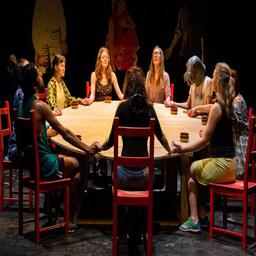

---------------------Actual---------------------
startseq <org> left <person> <person> and <person> with other cast members at <org> endseq
--------------------Predicted--------------------
startseq fans praying in <date> endseq


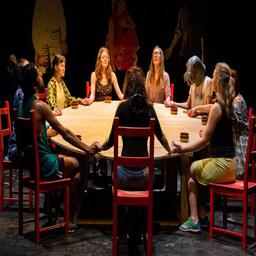

---------------------Actual---------------------
startseq <org> left <person> <person> and <person> with other cast members at <org> endseq
--------------------Predicted--------------------
startseq <person> and <person> in <gpe> endseq


In [30]:
generate_caption("5568fc4338f0d87c79ae603e_1.jpg",model_10,features,loaded_tokenizer,107)
generate_caption("5568fc4338f0d87c79ae603e_1.jpg",model_20,features,loaded_tokenizer,107)

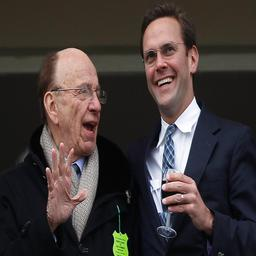

---------------------Actual---------------------
startseq as <person> nears <cardinal> many see his son <person> as the heir apparent endseq
--------------------Predicted--------------------
startseq <person> the chief executive of <org> in <date> endseq


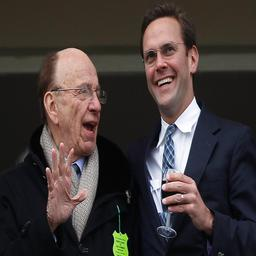

---------------------Actual---------------------
startseq as <person> nears <cardinal> many see his son <person> as the heir apparent endseq
--------------------Predicted--------------------
startseq <person> left and <person> in <gpe> endseq


In [31]:
generate_caption("540af3be38f0d84fb8834395_0.jpg",model_10,features,loaded_tokenizer,107)
generate_caption("540af3be38f0d84fb8834395_0.jpg",model_20,features,loaded_tokenizer,107)

## Evaluate model on test images

In [32]:
def evaluate(test_data, model, features, tokenizer, max_length):
    # validate with test data
    actual, predicted = list(), list()

    for key in tqdm(test_data):
        # get actual caption
        captions = mapping[key]
        # predict the caption for image
        y_pred = predict_caption(model, features[key], tokenizer, max_length) 
        # split into words
        actual_captions = [caption.split() for caption in captions]
        y_pred = y_pred.split()
        # append to the list
        actual.append(actual_captions)
        predicted.append(y_pred)
        
    # calcuate BLEU score
    print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

In [28]:
evaluate(test, model_10, features, loaded_tokenizer, 107)

  0%|          | 0/800 [00:00<?, ?it/s]

BLEU-1: 0.225391
BLEU-2: 0.105018


BLEU-1: 0.225391
BLEU-2: 0.105018

In [33]:
evaluate(test, model_20, features, loaded_tokenizer, 107)

  0%|          | 0/800 [00:00<?, ?it/s]

BLEU-1: 0.253347
BLEU-2: 0.115936


BLEU-1: 0.253347
BLEU-2: 0.115936